# Neoclassical transport and fast ions
- In this tutorial, we will show how to optimize for the effective ripple in DESC.
The computation involves integration over ripple wells whose structure determines the optimal resolution for the optimization.
So we will also breifly show how to visualize the ripples and accordingly pick resolution parameters.
The same tutorial can be used to optimize for fast ion confinement with Γ_c. To do so, replace the objective ``EffectiveRipple`` with ``GammaC``.

- Note that there is still work in progress to improve the performance in DESC by an order of magnitude. See the GitHub issues linked in the objective docstring if you would like to contribute.

## Neoclassical transport in banana regime
A 3D stellarator magnetic field admits ripple wells that lead to enhanced
radial drift of trapped particles. In the banana regime, neoclassical (thermal)
transport from ripple wells can become the dominant transport channel.
The effective ripple (ε) proxy estimates the neoclassical transport
coefficients in the banana regime. To ensure low neoclassical transport,
a stellarator is typically optimized so that ε < 0.02.

## Fast ion confinement
The energetic particle confinement
metric γ_c quantifies whether the contours of the second adiabatic invariant
close on the flux surfaces. In the limit where the poloidal drift velocity
dominates the radial drift velocity, the contours lie parallel to flux
surfaces. The optimization metric Γ_c averages γ_c² over the distribution
of trapped particles on each flux surface.
The radial electric field has a negligible effect, since fast particles
have high energy with collisionless orbits, so it is assumed to be zero.

## References
- [Evaluation of 1/ν neoclassical transport in stellarators.](https://doi.org/10.1063/1.873749)
V. V. Nemov, S. V. Kasilov, W. Kernbichler, M. F. Heyn.
Phys. Plasmas 1 December 1999; 6 (12): 4622–4632.
- [Poloidal motion of trapped particle orbits in real-space coordinates.](
https://doi.org/10.1063/1.2912456)
V. V. Nemov, S. V. Kasilov, W. Kernbichler, G. O. Leitold.
Phys. Plasmas 1 May 2008; 15 (5): 052501.
- [Spectrally accurate, reverse-mode differentiable bounce-averaging
    algorithm and its applications.](https://arxiv.org/abs/2412.01724)
    Kaya E. Unalmis, Rahul Gaur, Rory Conlin, Dario Panici, Egemen Kolemen.

In [1]:
# If DESC is not installed as described in the installation documentation,
# then these lines may be needed to run this notebook.
#
# import sys
# import os

# sys.path.insert(0, os.path.abspath("."))
# sys.path.append(os.path.abspath("../../../"))

If you have access to a GPU, uncomment the following two lines before any DESC or JAX related imports. You should see about an order of magnitude speed improvement with only these two lines of code!

In [2]:
# from desc import set_device

# set_device("gpu")

As mentioned in [DESC Documentation on performance tips](https://desc-docs.readthedocs.io/en/latest/performance_tips.html), one can use compilation cache directory to reduce the compilation overhead time. Note: One needs to create `jax-caches` folder manually.

In [3]:
# import jax

# jax.config.update("jax_compilation_cache_dir", "../jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [4]:
import numpy as np
from matplotlib import pyplot as plt

from desc.integrals import Bounce2D
from desc.examples import get
from desc.grid import LinearGrid, Grid
from desc.optimize import Optimizer
from desc.objectives import (
    ForceBalance,
    FixPsi,
    FixBoundaryR,
    FixBoundaryZ,
    GenericObjective,
    FixPressure,
    FixIota,
    AspectRatio,
    EffectiveRipple,
    ObjectiveFunction,
)

## Documentation
Please read the full documentation of the methods to understand what the input parameters do. In Jupyter Lab, you can click on the code and press ``Shift+Tab`` to pull up the documentation. Breifly,

- The equilibrium resolution determines the spectral resolution of the FourierZernike series fit to the boundary.
- The grid determines the flux surfaces to compute on and the resolution of FFTs.
- The parameters ``X`` and ``Y`` determine the spectral resolution of the map between coordinates that parameterize the boundary and field line coordinates.
- The parameter ``Y_B`` determines the resolution for the bounce point finding algorithm. Feel free to reduce this until the plots of $\vert B\vert$ along field lines do not change. If $\vert B\vert$ is high frequency, then a larger value will be needed (larger than ``Y``).

## Frequency spectrum of the map to the mesh of field lines

- First, let us view the spectrum of the map between coordinates that parameterize the boundary and coordinates that parameterize the magnetic field line trajectory.
- This should give you some intuition on how to pick the resolution for the parameters ``X`` and ``Y``.
- For example, let us view this spectrum on a few different flux surfaces of the `precise QH` equilibrium from the DESC examples folder.

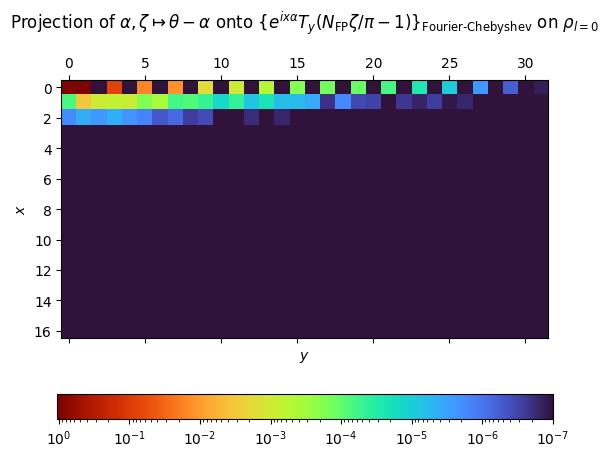

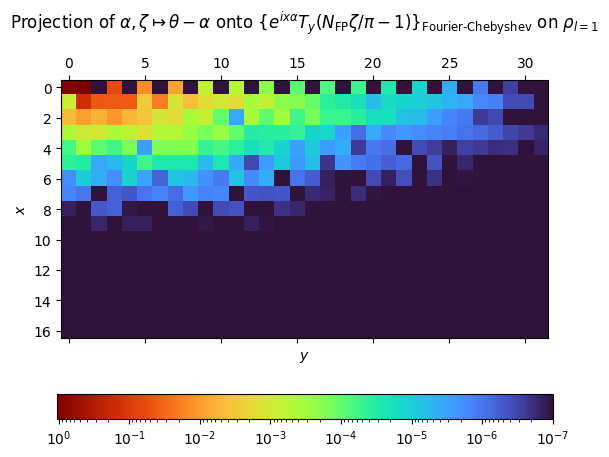

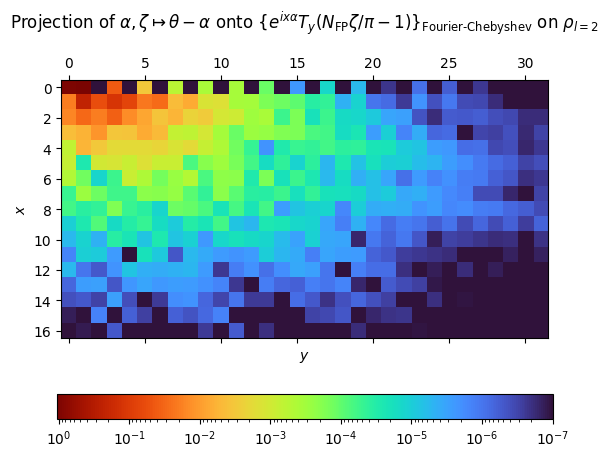

In [5]:
eq = get("precise_QH")
rho = np.linspace(0.01, 1, 3)
angle = Bounce2D.angle(eq, X=32, Y=32, rho=rho)
for l in range(rho.size):
    fig = Bounce2D.plot_angle_spectrum(angle, l)

- Flux surface averaged bounce integrals seem to be well-conditioned to discretization error in this map. If the spectrum is green at the high frequency edges, then ``X`` and ``Y`` are large enough.

## Plotting ripple wells

- Here we plot $\vert B\vert$ along field lines to see the structure of the ripple wells. This is beneficial to choose the resolution for the optimization.
- Due to limitations in JAX, it is recommended to plot the field lines and pick a reasonable, yet preferably tight, upper bound on the number of ripple wells. From the plots, we see that ``num_well=W * num_transit`` with ``W=10`` is a reasonable upper bound. By making this extra effort, the optimization will be ``Y_B/W`` times more performant. If one were to select something much less than ``10``, as shown in the next example, then it should be clear from the plot that some ripple wells are ignored, which is not desirable.
- Making a good choice for ``num_well`` is important for performance in optimization.

In [6]:
def plot_wells(
    eq,
    grid,
    angle,
    Y_B=None,
    num_transit=3,
    num_well=None,
    num_pitch=10,
):
    """Plotting tool to help user set tighter upper bound on ``num_well``.

    Parameters
    ----------
    eq : Equilibrium
        Equilibrium to compute on.
    grid : Grid
        Tensor-product grid in (ρ, θ, ζ) with uniformly spaced nodes
        (θ, ζ) ∈ [0, 2π) × [0, 2π/NFP).
        Number of poloidal and toroidal nodes preferably rounded down to powers of two.
        Determines the flux surfaces to compute on and resolution of FFTs.
    angle : jnp.ndarray
        Shape (num rho, X, Y).
        Angle returned by ``Bounce2D.angle``.
    Y_B : int
        Desired resolution for algorithm to compute bounce points.
        Default is double ``Y``.
    num_transit : int
        Number of toroidal transits to follow field line.
        In an axisymmetric device, field line integration over a single poloidal
        transit is sufficient to capture a surface average. For a 3D
        configuration, more transits will approximate surface averages on an
        irrational magnetic surface better, with diminishing returns.
    num_well : int
        Maximum number of wells to detect for each pitch and field line.
        Giving ``-1`` will detect all wells but due to current limitations in
        JAX this will have worse performance.
        Specifying a number that tightly upper bounds the number of wells will
        increase performance. In general, an upper bound on the number of wells
        per toroidal transit is ``Aι+C`` where ``A``, ``C`` are the poloidal and
        toroidal Fourier resolution of B, respectively, in straight-field line
        PEST coordinates, and ι is the rotational transform normalized by 2π.
        A tighter upper bound than ``num_well=(Aι+C)*num_transit`` is preferable.
        The ``check_points`` or ``plot`` methods in ``desc.integrals.Bounce2D``
        are useful to select a reasonable value.
    num_pitch: int
        Number of pitch angles.

    Returns
    -------
    plots
        Matplotlib (fig, ax) tuples for the 1D plot of each field line.

    """
    data = eq.compute(Bounce2D.required_names + ["min_tz |B|", "max_tz |B|"], grid=grid)
    bounce = Bounce2D(grid, data, angle, Y_B, num_transit=num_transit)
    pitch_inv, _ = Bounce2D.get_pitch_inv_quad(
        grid.compress(data["min_tz |B|"]),
        grid.compress(data["max_tz |B|"]),
        num_pitch,
    )
    points = bounce.points(pitch_inv, num_well)
    plots = bounce.check_points(points, pitch_inv)
    return plots

We plot the magnetic field norm over 3 toroidal transits (12 field periods) to educate our guess for the ``num_well`` parameter.

E1225 10:35:15.458290   70839 custom_call_thunk.cc:209] Custom call API version `API_VERSION_STATUS_RETURNING` is not supported by XLA:CPU. Prefer https://docs.jax.dev/en/latest/ffi.html. It will be fully removed in November 2025. Custom call target: nufft1d2


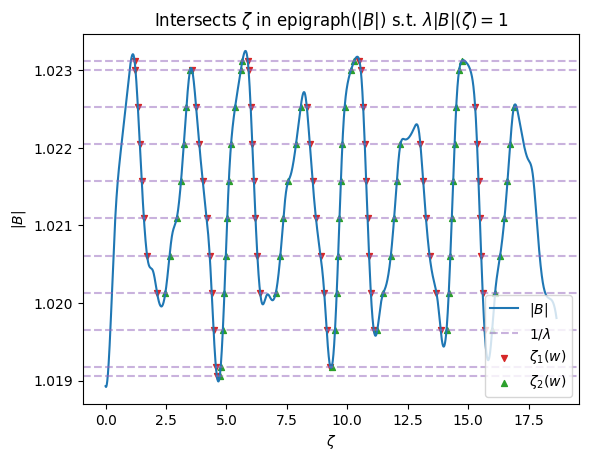

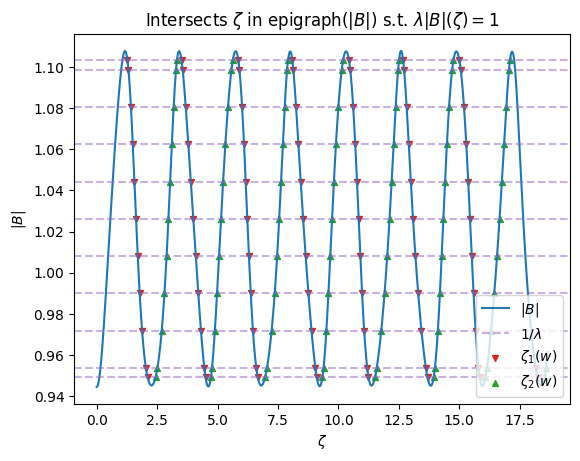

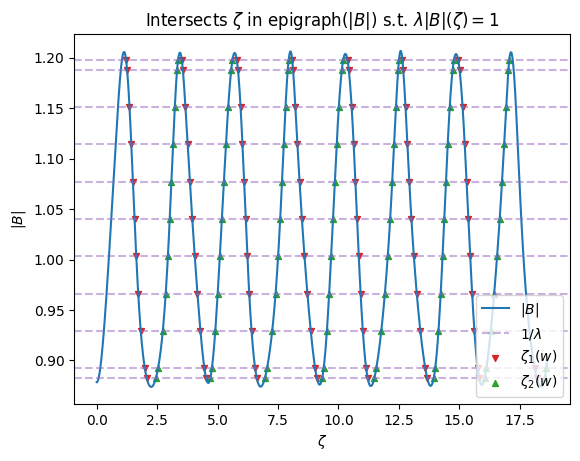

In [7]:
grid = LinearGrid(rho=rho, M=eq.M_grid, N=eq.N_grid, NFP=eq.NFP, sym=False)
angle = Bounce2D.angle(eq, X=16, Y=16, rho=rho)
num_transit = 3
Y_B = 32

plot_wells(
    eq,
    grid,
    angle,
    Y_B,
    num_transit,
    num_well=10 * num_transit,
);

- Let us plot these again with a lower choice for ``num_well``.
- We observe some wells are not detected. Notice the triangular markers that indicate the detection of a bounce point are missing.
- These plots are better viewed in interactive Python sessions where you can zoom in etc. An interactive session is usually started automatically if running a Python file instead of a Jupyter notebook cell.

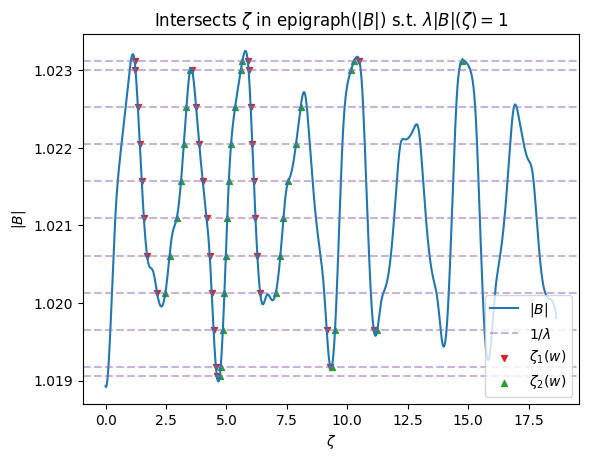

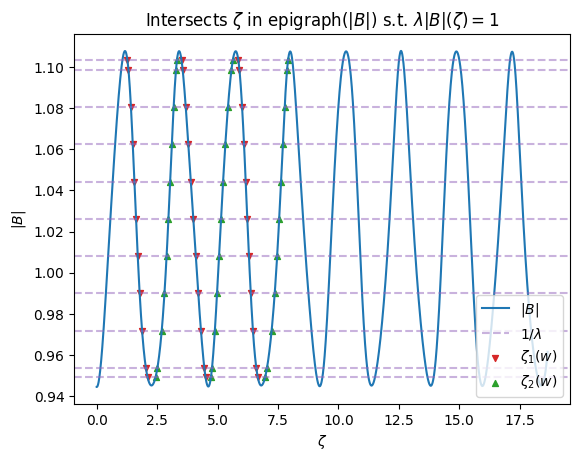

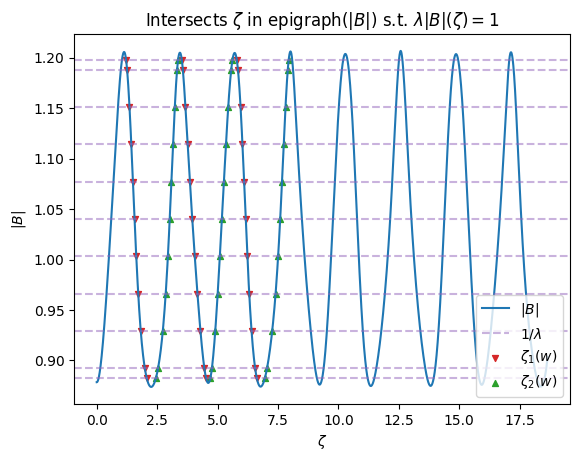

In [8]:
plot_wells(
    eq,
    grid,
    angle,
    Y_B,
    num_transit,
    num_well=1 * num_transit,
);

## Calculating effective ripple for Precise QH

- If your machine has insufficient memory, then you should specify the parameter ``pitch_batch_size`` to some value less than ``num_pitch``. Recall this determines the number of pitch values to compute simultaneously.
- Some machines detect insufficient memory early, exit early, and return ε = 0 everywhere. On most machines you should get a typical OOM error.

In [9]:
rho = np.linspace(0.01, 1, 10)
grid = LinearGrid(rho=rho, M=eq.M_grid, N=eq.N_grid, NFP=eq.NFP, sym=False)
num_transit = 10
data = eq.compute(
    "effective ripple",
    grid,
    angle=Bounce2D.angle(eq, X=16, Y=16, rho=rho),
    Y_B=Y_B,
    num_transit=num_transit,
    num_well=15 * num_transit,
    num_quad=16,
    num_pitch=15,
)
eps = grid.compress(data["effective ripple"])

E1225 10:35:32.996317   70839 custom_call_thunk.cc:209] Custom call API version `API_VERSION_STATUS_RETURNING` is not supported by XLA:CPU. Prefer https://docs.jax.dev/en/latest/ffi.html. It will be fully removed in November 2025. Custom call target: nufft1d2
E1225 10:35:33.213360   70839 custom_call_thunk.cc:209] Custom call API version `API_VERSION_STATUS_RETURNING` is not supported by XLA:CPU. Prefer https://docs.jax.dev/en/latest/ffi.html. It will be fully removed in November 2025. Custom call target: nufft2d2


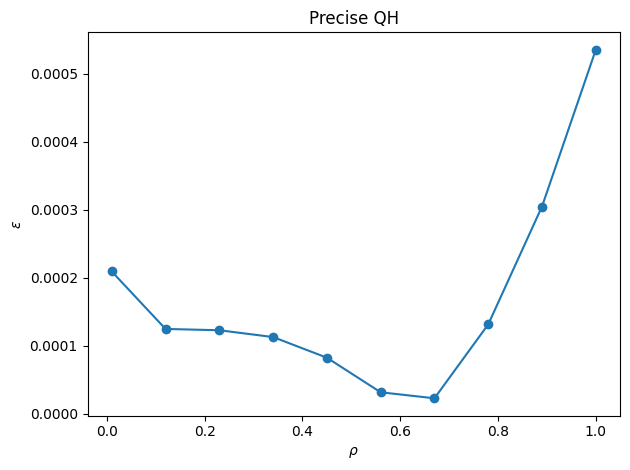

In [10]:
fig, ax = plt.subplots()
ax.plot(rho, eps, marker="o")
ax.set(xlabel=r"$\rho$", ylabel=r"$\epsilon$", title="Precise QH")
plt.tight_layout()
plt.show()

## Calculating effective ripple for Heliotron

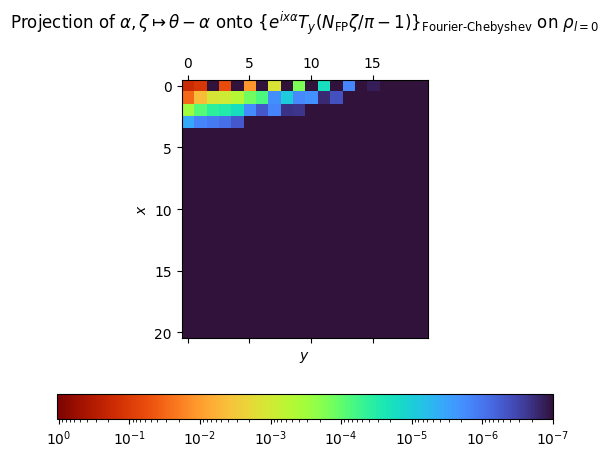

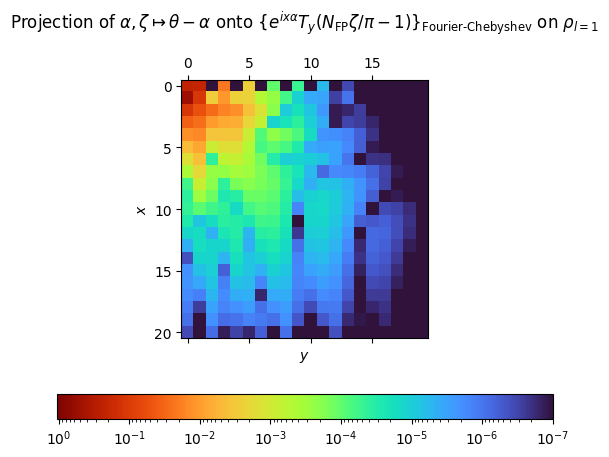

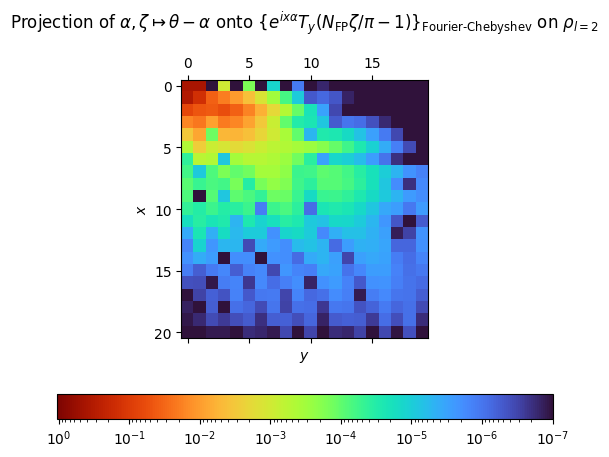

In [11]:
rho = np.linspace(0.01, 1, 3)
eq0 = get("HELIOTRON")
angle = Bounce2D.angle(eq0, X=40, Y=20, rho=rho)
for l in range(rho.size):
    fig = Bounce2D.plot_angle_spectrum(angle, l)

In [12]:
rho = np.linspace(0.01, 1, 10)
angle = Bounce2D.angle(eq0, X=32, Y=20, rho=rho)
grid = LinearGrid(rho=rho, M=eq0.M_grid, N=eq0.N_grid, NFP=eq0.NFP, sym=False)
Y_B = 133
num_transit = 20
num_well = 25 * num_transit
num_quad = 48
num_pitch = 45
data = eq0.compute(
    "effective ripple",
    grid,
    angle=angle,
    Y_B=Y_B,
    num_transit=num_transit,
    num_well=num_well,
    num_quad=num_quad,
    num_pitch=num_pitch,
)
eps = grid.compress(data["effective ripple"])

E1225 10:35:51.159251   70839 custom_call_thunk.cc:209] Custom call API version `API_VERSION_STATUS_RETURNING` is not supported by XLA:CPU. Prefer https://docs.jax.dev/en/latest/ffi.html. It will be fully removed in November 2025. Custom call target: nufft1d2
E1225 10:35:51.428929   70839 custom_call_thunk.cc:209] Custom call API version `API_VERSION_STATUS_RETURNING` is not supported by XLA:CPU. Prefer https://docs.jax.dev/en/latest/ffi.html. It will be fully removed in November 2025. Custom call target: nufft2d2


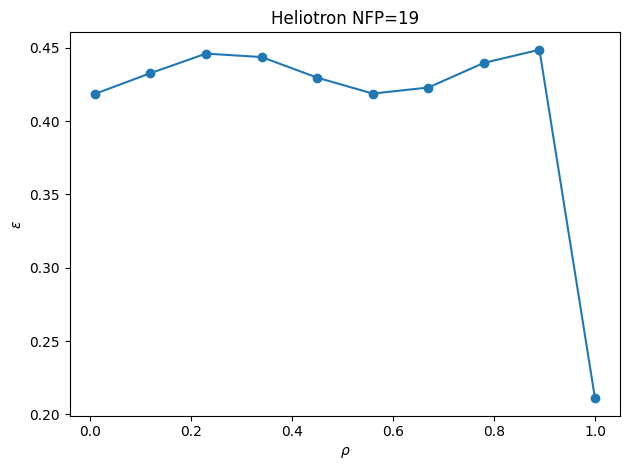

In [13]:
fig, ax = plt.subplots()
ax.plot(rho, eps, marker="o")
ax.set(xlabel=r"$\rho$", ylabel=r"$\epsilon$", title="Heliotron NFP=19")
plt.tight_layout()
plt.show()

Let us also compute this quantity using an older lower-order accurate algorithm and compare the results.

In [14]:
low_order_eps_grid = Grid.create_meshgrid(
    [
        rho,
        np.array([0]),
        np.linspace(0, num_transit * 2 * np.pi, num_transit * 200),
    ],
    coordinates="raz",
)
low_order_eps = eq0.compute(
    "old effective ripple",
    low_order_eps_grid,
    num_well=num_well,
    num_quad=num_quad,
    num_pitch=num_pitch,
)["old effective ripple"]
low_order_eps = low_order_eps_grid.compress(low_order_eps)

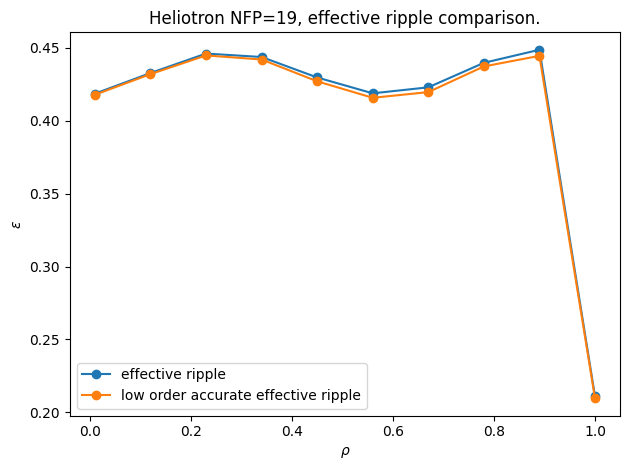

In [15]:
fig, ax = plt.subplots()
ax.set(
    xlabel=r"$\rho$",
    ylabel=r"$\epsilon$",
    title="Heliotron NFP=19, effective ripple comparison.",
)
ax.plot(rho, eps, marker="o", label="effective ripple")
ax.plot(rho, low_order_eps, marker="o", label="low order accurate effective ripple")
plt.legend()
plt.tight_layout()
plt.show()

## Optimizing Heliotron

In [16]:
eq1 = eq0.copy()
k = 1
print()
print("---------------------------------------")
print(f"Optimizing boundary modes M, N <= {k}")
print("---------------------------------------")
modes_R = np.vstack(
    (
        [0, 0, 0],
        eq1.surface.R_basis.modes[np.max(np.abs(eq1.surface.R_basis.modes), 1) > k, :],
    )
)
modes_Z = eq1.surface.Z_basis.modes[np.max(np.abs(eq1.surface.Z_basis.modes), 1) > k, :]
constraints = (
    ForceBalance(eq=eq1),
    FixBoundaryR(eq=eq1, modes=modes_R),
    FixBoundaryZ(eq=eq1, modes=modes_Z),
    FixPressure(eq=eq1),
    FixIota(eq=eq1),
    FixPsi(eq=eq1),
)
curvature_grid = LinearGrid(
    rho=np.array([1.0]), M=eq1.M_grid, N=eq1.N_grid, NFP=eq1.NFP, sym=eq1.sym
)
ripple_grid = LinearGrid(
    rho=np.linspace(0.2, 1, 5), M=eq1.M_grid, N=eq1.N_grid, NFP=eq1.NFP, sym=False
)
objective = ObjectiveFunction(
    (
        EffectiveRipple(
            eq1,
            grid=ripple_grid,
            X=32,
            Y=20,
            Y_B=133,
            num_transit=10,
            num_well=24 * 10,
            num_quad=32,
            num_pitch=45,
        ),
        AspectRatio(eq1, bounds=(8, 11), weight=1e2),
        GenericObjective(
            "curvature_k2_rho",
            eq1,
            grid=curvature_grid,
            bounds=(-128, 10),
            weight=2e2,
        ),
    )
)
optimizer = Optimizer("proximal-lsq-exact")
(eq1,), _ = optimizer.optimize(
    eq1,
    objective,
    constraints,
    ftol=1e-4,
    xtol=1e-6,
    gtol=1e-6,
    maxiter=7,
    verbose=3,
    options={"initial_trust_ratio": 2e-3},
)
print("Optimization complete!")


---------------------------------------
Optimizing boundary modes M, N <= 1
---------------------------------------
Building objective: Effective ripple
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 111 ms
Building objective: Generic
Timer: Objective build = 4.44 sec
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 155 ms
Timer: Objective build = 1.17 sec
Timer: Objective build = 3.24 ms
Timer: Eq Update LinearConstraintProjection build = 6.45 sec
Timer: Proximal projection build = 46.1 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed Psi
Timer: Objective build = 1.74 sec
Timer: LinearConstraintProjection build = 2.10 sec
Number of parameters: 8
Number of objectives: 253
Timer: Initializing the optimization = 50.1 sec

Starting optimization
Using method: proximal-lsq-exact


E1225 10:37:42.206029   70839 custom_call_thunk.cc:209] Custom call API version `API_VERSION_STATUS_RETURNING` is not supported by XLA:CPU. Prefer https://docs.jax.dev/en/latest/ffi.html. It will be fully removed in November 2025. Custom call target: nufft1d2
E1225 10:37:42.509272   70839 custom_call_thunk.cc:209] Custom call API version `API_VERSION_STATUS_RETURNING` is not supported by XLA:CPU. Prefer https://docs.jax.dev/en/latest/ffi.html. It will be fully removed in November 2025. Custom call target: nufft2d2
E1225 10:38:10.763781   70839 custom_call_thunk.cc:209] Custom call API version `API_VERSION_STATUS_RETURNING` is not supported by XLA:CPU. Prefer https://docs.jax.dev/en/latest/ffi.html. It will be fully removed in November 2025. Custom call target: nufft1d2
E1225 10:38:10.763805   70839 custom_call_thunk.cc:209] Custom call API version `API_VERSION_STATUS_RETURNING` is not supported by XLA:CPU. Prefer https://docs.jax.dev/en/latest/ffi.html. It will be fully removed in Nove

Solver options:
------------------------------------------------------------
Maximum Function Evaluations       : 36
Maximum Allowed Total Δx Norm      : inf
Scaled Termination                 : True
Trust Region Method                : qr
Initial Trust Radius               : 1.717e-02
Maximum Trust Radius               : inf
Minimum Trust Radius               : 2.220e-16
Trust Radius Increase Ratio        : 2.000e+00
Trust Radius Decrease Ratio        : 2.500e-01
Trust Radius Increase Threshold    : 7.500e-01
Trust Radius Decrease Threshold    : 2.500e-01
------------------------------------------------------------ 

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          4.081e-01                                    8.146e-01   
       1              2          3.844e-01      2.372e-02      4.459e-03      7.050e-01   
       2              3          3.397e-01      4.463e-02      7.856e-03      6.431e-01   
       3  

E1225 10:53:50.114643   70839 custom_call_thunk.cc:209] Custom call API version `API_VERSION_STATUS_RETURNING` is not supported by XLA:CPU. Prefer https://docs.jax.dev/en/latest/ffi.html. It will be fully removed in November 2025. Custom call target: nufft1d2
E1225 10:53:50.426388   70839 custom_call_thunk.cc:209] Custom call API version `API_VERSION_STATUS_RETURNING` is not supported by XLA:CPU. Prefer https://docs.jax.dev/en/latest/ffi.html. It will be fully removed in November 2025. Custom call target: nufft2d2
E1225 10:53:55.132643   70839 custom_call_thunk.cc:209] Custom call API version `API_VERSION_STATUS_RETURNING` is not supported by XLA:CPU. Prefer https://docs.jax.dev/en/latest/ffi.html. It will be fully removed in November 2025. Custom call target: nufft1d2
E1225 10:53:55.410534   70839 custom_call_thunk.cc:209] Custom call API version `API_VERSION_STATUS_RETURNING` is not supported by XLA:CPU. Prefer https://docs.jax.dev/en/latest/ffi.html. It will be fully removed in Nove

                                                                 Start  -->   End
Total (sum of squares):                                      4.081e-01  -->   1.207e-01, 
Maximum absolute Effective ripple ε:                         4.465e-01  -->   2.942e-01 ~
Minimum absolute Effective ripple ε:                         2.469e-01  -->   1.315e-01 ~
Average absolute Effective ripple ε:                         3.969e-01  -->   2.118e-01 ~
Maximum absolute Effective ripple ε:                         4.465e-01  -->   2.942e-01 (normalized)
Minimum absolute Effective ripple ε:                         2.469e-01  -->   1.315e-01 (normalized)
Average absolute Effective ripple ε:                         3.969e-01  -->   2.118e-01 (normalized)
Aspect ratio:                                                1.048e+01  -->   1.098e+01 (dimensionless)
Maximum Generic objective value:                            -6.864e-01  -->  -6.915e-01 (m^{-1})
Minimum Generic objective value:                      

In [17]:
data = eq1.compute(
    "effective ripple",
    grid,
    angle=Bounce2D.angle(eq1, X=40, Y=20, rho=rho),
    Y_B=Y_B,
    num_transit=num_transit,
    num_well=num_well,
    num_quad=num_quad,
    num_pitch=num_pitch,
)
eps_opt = grid.compress(data["effective ripple"])

E1225 10:54:02.635695   70839 custom_call_thunk.cc:209] Custom call API version `API_VERSION_STATUS_RETURNING` is not supported by XLA:CPU. Prefer https://docs.jax.dev/en/latest/ffi.html. It will be fully removed in November 2025. Custom call target: nufft1d2
E1225 10:54:02.926928   70839 custom_call_thunk.cc:209] Custom call API version `API_VERSION_STATUS_RETURNING` is not supported by XLA:CPU. Prefer https://docs.jax.dev/en/latest/ffi.html. It will be fully removed in November 2025. Custom call target: nufft2d2


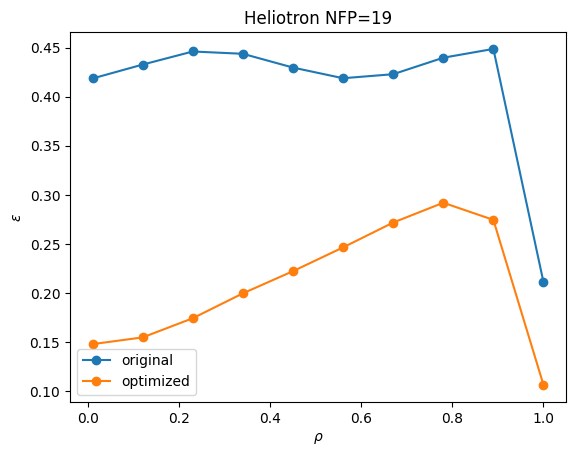

In [18]:
fig, ax = plt.subplots()
ax.plot(rho, eps, marker="o", label="original")
ax.plot(rho, eps_opt, marker="o", label="optimized")
ax.set(xlabel=r"$\rho$", ylabel=r"$\epsilon$", title="Heliotron NFP=19")
ax.legend();

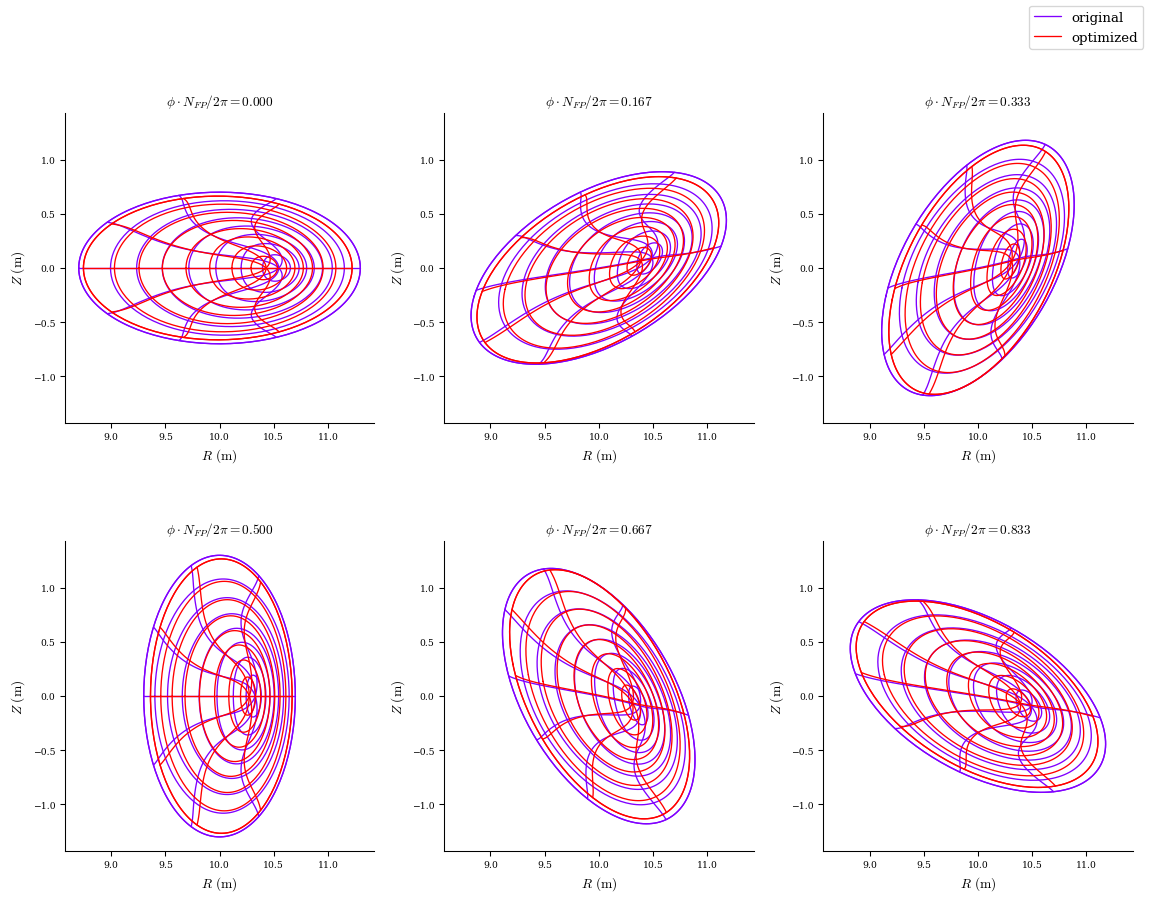

In [19]:
from desc.plotting import plot_comparison

plot_comparison(eqs=[eq0, eq1], labels=["original", "optimized"]);